In [2]:
import os
import sys

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/home/self_supervised_learning_gr/self_supervised_learning/dev/ProjetCassiopee")
from src.setup import setup_python, setup_pytorch
from src.transformation.custom_crop import ObjectCrop
from src.dataset import RGBDObjectDataset, RGBDObjectDataset_Supervised_Contrast
from src.models.rgbd_object.autoencoder import TestAutoencoder, TestAutoencoder_skip, ResNetAutoencoder, test
from src.plot.tsne_plot import tsne_2d_plot, tsne_3d_plot

/home/self_supervised_learning_gr/self_supervised_learning/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
setup_python()

In [4]:
DEVICE = setup_pytorch()

In [5]:
BATCH_SIZE = 10 # Batch size
INPUT_SIZE = (256,256)
TRANSFORMATION = None
CROP_TRANSFORMATION = ObjectCrop(output_size=INPUT_SIZE,
                                 padding=(20,20),
                                 offset_range=(-10,10))
NB_MAX_TEST_SAMPLES = 1000

test_dataset = RGBDObjectDataset(path="../../../data/RGB-D_Object/rgbd-dataset",
                                 mode="test",
                                 transformation=TRANSFORMATION,
                                 crop_transformation=CROP_TRANSFORMATION,
                                 nb_max_samples=NB_MAX_TEST_SAMPLES)

test_data_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [6]:
# model = TestAutoencoder().to(DEVICE)

# model = TestAutoencoder_skip().to(DEVICE)

model = ResNetAutoencoder().to(DEVICE)

In [7]:
weight_path = "ae_20240403_221529/weights_epoch_1_batch_1000"
model.load_state_dict(torch.load(weight_path))
model = model.to(DEVICE)

In [8]:
# Test
tsne_results_2d, tsne_results_3d, labels = test(model,
                                                test_data_loader,
                                                True,
                                                DEVICE)

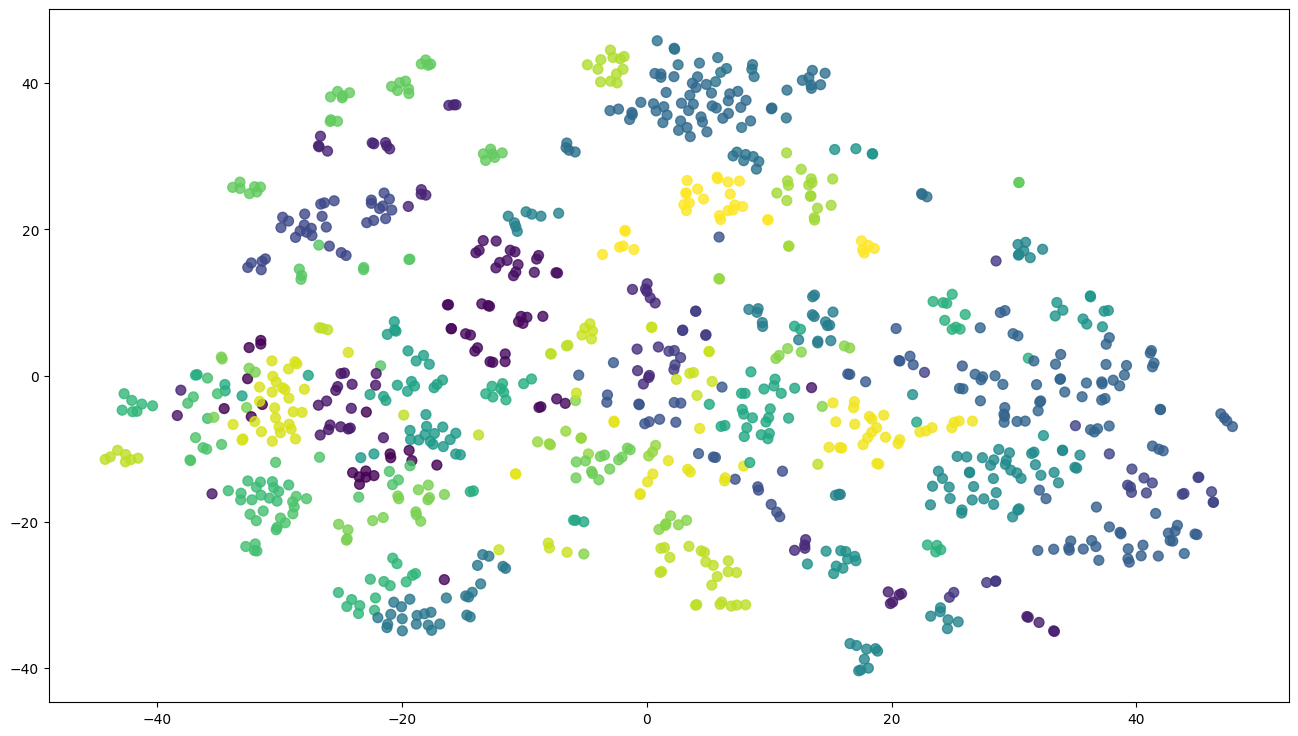

In [9]:
tsne_2d_plot(tsne_results_2d, labels)

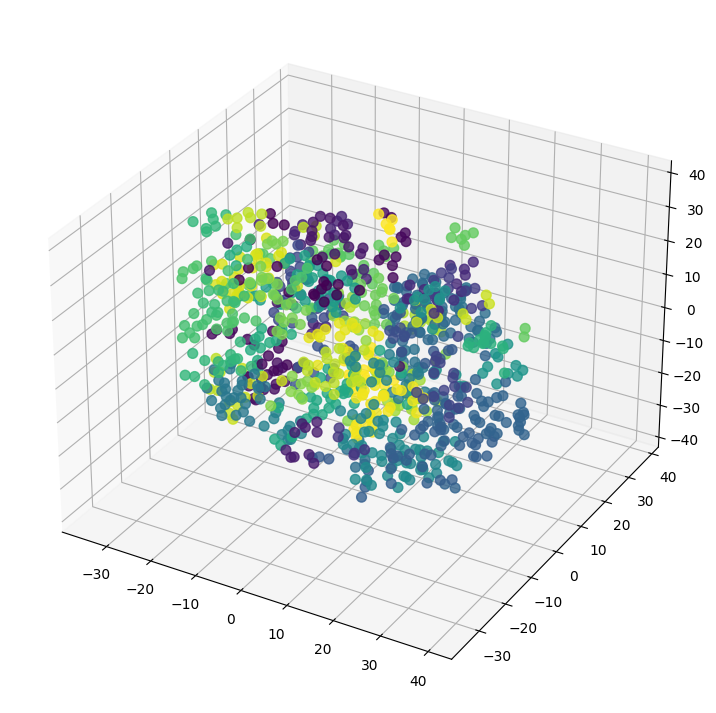

In [10]:
tsne_3d_plot(tsne_results_3d, labels)

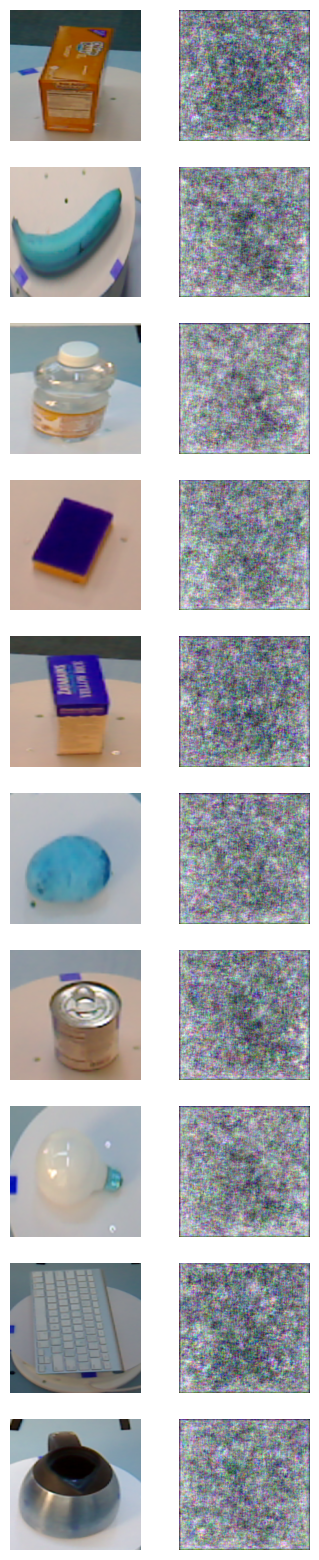

In [12]:
with torch.no_grad():
    # Retrieve batch data
    batch = next(iter(test_data_loader))

    # Load and prepare batch
    rgb, depth, mask, loc_x, loc_y, label = batch
    rgb = rgb.to(DEVICE)
    # depth = depth.to(DEVICE)
    # mask = mask.to(DEVICE)
    # loc_x = loc_x.to(DEVICE)
    # loc_y = loc_y.to(DEVICE)
    label = label.to(DEVICE)
        
    # Make predictions for batch
    encoded, decoded = model(rgb)

    fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(4, 20))
    for i in range(BATCH_SIZE):
        rgb_, decoded_ = rgb[i], decoded[i]
        rgb_, decoded_ = rgb_.cpu(), decoded_.cpu()
        
        axs[i,0].imshow(rgb_.permute(1, 2, 0))
        axs[i,0].set_axis_off()
        axs[i,1].imshow(decoded_.permute(1, 2, 0))
        axs[i,1].set_axis_off()
    plt.show()